In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_validation, evidence_meta_validation
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.models import HierarchicalSdtMptSimulator, MainSimulator
from src.python.helpers import n_clust_obs_f_f, get_multiple_predictions, get_preds_and_bfs
from src.python.visualization import perf_tester, plot_calibration_curve, plot_calibration_curve_repetition_uncertainty

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.experimental import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam
from functools import partial
from time import perf_counter
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Set up networks

In [3]:
summary_net = HierarchicalInvariantNetwork(summary_meta_validation)
evidence_net = EvidentialNetwork(evidence_meta_validation)

amortizer = MultiModelAmortizer(evidence_net, summary_net)

simulator = MainSimulator(HierarchicalSdtMptSimulator())

In [4]:
from bayesflow.losses import kl_dirichlet

# custom loss with label smoothing

def multi_task_loss(network, model_indices, sim_data, kl_weight=0.01):
    """ Computes the logloss given output probs and true model indices m_true.
    Parameters
    ----------
    network       : tf.keras.Model
        An evidential network (with real outputs in ``[1, +inf]``)
    model_indices : tf.Tensor of shape (batch_size, n_models)
        True model indices
    sim_data      : tf.Tensor of shape (batch_size, n_obs, data_dim) or (batch_size, summary_dim) 
        Synthetic data sets generated by the params or summary statistics thereof
    kl_weight         : float in [0, 1]
        The weight of the KL regularization term
    Returns
    -------
    loss : tf.Tensor
        A single scalar Monte-Carlo approximation of the regularized Bayes risk, shape (,)
    """

    # Compute evidences + softmax probabilities
    alpha, softmax_probs = network(sim_data)

    # Process evidential output
    # Obtain probs
    model_probs = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)
    # Numerical stability
    model_probs = tf.clip_by_value(model_probs, 1e-15, 1 - 1e-15)
    # Compute evidential loss + regularization (if given)
    evidential_loss = -tf.reduce_mean(tf.reduce_sum(model_indices * tf.math.log(model_probs), axis=1))
    if kl_weight > 0:
        kl = kl_dirichlet(model_indices, alpha)
        evidential_loss = evidential_loss + kl_weight * kl

    # Process softmax output
    # Numerical stability
    softmax_probs = tf.clip_by_value(softmax_probs, 1e-15, 1 - 1e-15)
    # Compute softmax loss
    softmax_loss = -tf.reduce_mean(tf.reduce_sum(model_indices * tf.math.log(softmax_probs), axis=1))

    # Combine losses 
    loss = evidential_loss + softmax_loss

    return loss

In [5]:
# Cosine Decay with Restarts
initial_lr = 0.0005
first_decay_steps = 1000
t_mul = 2
m_mul = 0.9
alpha = 0.2
lr_schedule_restart = CosineDecayRestarts(
    initial_lr, first_decay_steps, t_mul=t_mul, m_mul=m_mul, alpha=alpha
    )

# Checkpoint path for loading pretrained network and saving the final network
checkpoint_path = "c:\\Users\\lasse\\documents\\hierarchical model comparison project\\checkpoints\\02_bridge_sampling_comparison\\non_nested_models"

trainer = ModelComparisonTrainer(
    network=amortizer, 
    generative_model=simulator, 
    loss=partial(multi_task_loss, kl_weight=0.25),
    optimizer=partial(Adam, lr_schedule_restart),
    #checkpoint_path=checkpoint_path,
    skip_checks=True,
    )

# Sample size
n_clusters = 100
n_obs = 50

# Train

In [6]:
losses = trainer.train_online(
    epochs=15, iterations_per_epoch=1000, batch_size=32, 
    n_obs=partial(n_clust_obs_f_f, n_clusters, n_obs), n_vars=2
    )

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Validate

In [7]:
# Simulate data
n_data_sets = 5000

m_val, _, x_val = simulator(batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2)
val_data = {'X' : x_val, 'm' : m_val}

ECE = 0.166


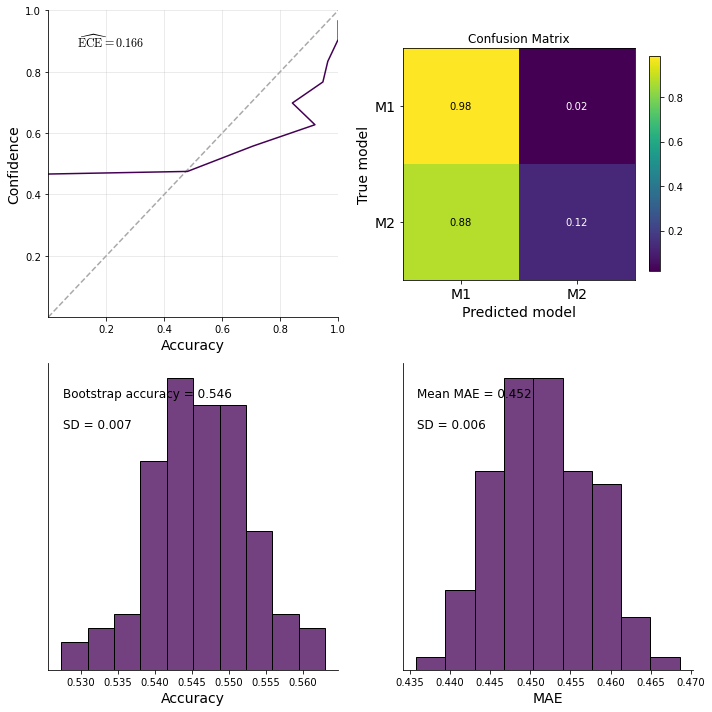

In [10]:
# Performance of the evidential output
perf_tester(evidence_net, summary_net, val_data, output_softmax=False, n_cal_bins=15)

ECE = 0.089


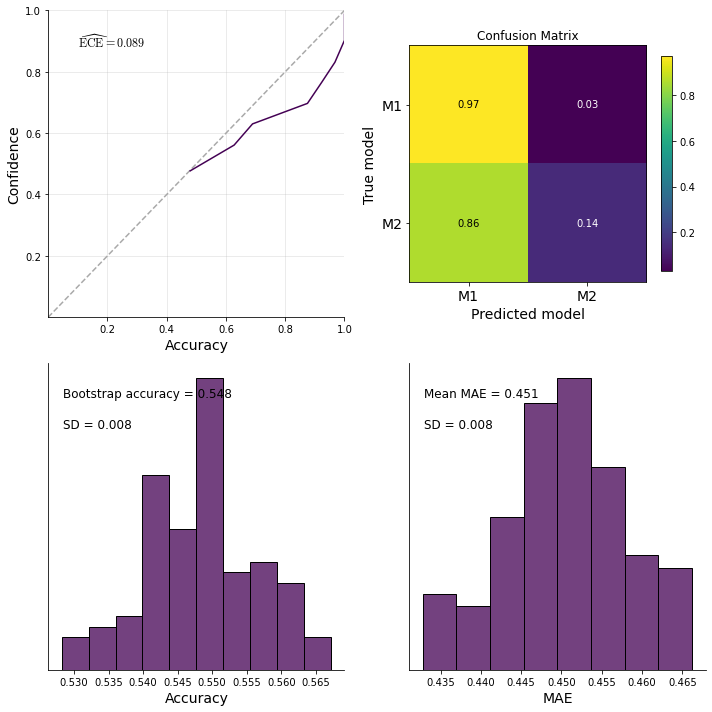

In [11]:
# Performance of the softmax output
perf_tester(evidence_net, summary_net, val_data, output_softmax=True, n_cal_bins=15)

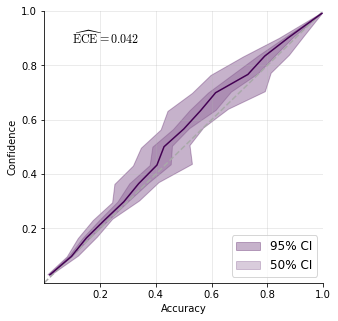

In [8]:
# Plot calibration with repetition uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))

m_true_r, m_soft_r = get_multiple_predictions(evidence_net, summary_net, partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                          n_models=2, procedure='repeated', n_repetitions=20)

plot_calibration_curve_repetition_uncertainty(m_true_r, m_soft_r, narrow_ci=[0.025, 0.975], wide_ci=[0.25, 0.75], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

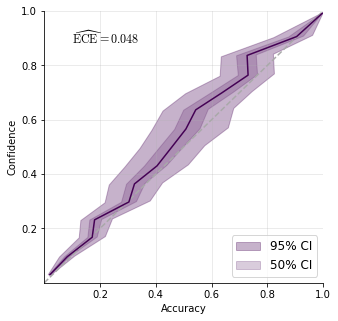

In [10]:
# Plot calibration with bootstrap uncertainty
fig, ax = plt.subplots(1, 1, figsize=(5,5))

m_true_b, m_soft_b = get_multiple_predictions(evidence_net, summary_net, partial(simulator, batch_size=n_data_sets, n_obs=n_clust_obs_f_f(n_clusters, n_obs), n_vars=2), 
                                          n_models=2, procedure='bootstrap', n_bootstrap=200)

plot_calibration_curve_repetition_uncertainty(m_true_b, m_soft_b, narrow_ci=[0.025, 0.975], wide_ci=[0.25, 0.75], n_bins=15, ax=ax, 
                                    xlabel=True, ylabel=True, title=None, show_ece=True, show_legend=True)

In [19]:
RNG = np.random.default_rng()
RNG.binomial(n=2, p=0.5, size=(5, 10)).T

array([[2, 1, 0, 1, 1],
       [1, 0, 0, 1, 2],
       [0, 2, 1, 0, 1],
       [1, 2, 2, 1, 2],
       [2, 1, 1, 1, 1],
       [1, 2, 1, 0, 0],
       [0, 0, 1, 1, 1],
       [0, 2, 2, 0, 2],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 0, 0]], dtype=int64)

# Calculate Bayes factors for bridge sampling comparison

In [ ]:
# TODO!